# Homework 3 Exercise 1
The first two problems are based on the same data. The data in data(foxes)
are 116 foxes from 30 different urban groups in England. These fox groups
are like street gangs. Group size (groupsize) varies from 2 to 8 individuals.
Each group maintains its own (almost exclusive) urban territory. Some ter-
ritories are larger than others. The area variable encodes this information.
Some territories also have more avgfood than others. And food influences
the weight of each fox. Assume this DAG:

In [1]:
# A -> F -> G
#      |   /
#      |  /
#      v v
#       W

where F is avgfood, G is groupsize, A is area, and W is weight.
Use the backdoor criterion and estimate the total causal influence of A on
F. What effect would increasing the area of a territory have on the amount
of food inside it?

In [2]:
using StatsPlots
using StatisticalRethinking: sr_datadir, PI
using StatisticalRethinkingCommon
using Statistics, StatsBase
import CSV
using DataFrames
using Gen, Distributions

In [3]:
@time data = CSV.read(sr_datadir("foxes.csv"), DataFrame)

  9.756968 seconds (2.74 M allocations: 121.500 MiB, 99.97% compilation time)


,group,avgfood,groupsize,area,weight
,Int64,Float64,Int64,Float64,Float64
1,1,0.37,2,1.09,5.02
2,1,0.37,2,1.09,2.84
3,2,0.53,2,2.05,5.33
4,2,0.53,2,2.05,6.07
5,3,0.49,2,2.12,5.85
6,3,0.49,2,2.12,3.25
7,4,0.45,2,1.29,4.53
8,4,0.45,2,1.29,4.09
9,5,0.74,3,3.78,6.13


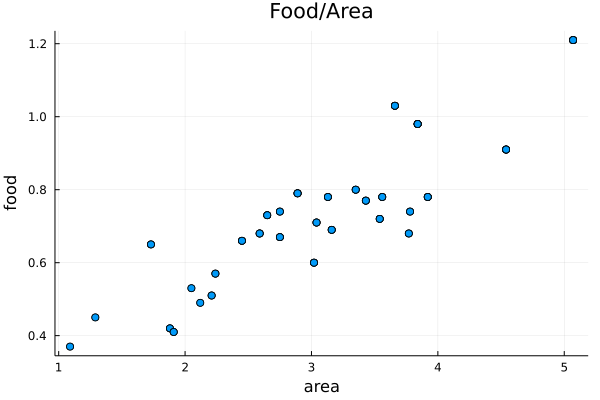

In [4]:
@df data plot(:area, :avgfood, seriestype=:scatter, title="Food/Area", xlabel="area", ylabel="food", labels=nothing, legend=false)

In [5]:
area_dt = standardize_column!(data, :area)
avgfood_dt = standardize_column!(data, :avgfood)
area_dt, avgfood_dt

(ZScoreTransform{Float64, Vector{Float64}}(1, 1, [3.169137931034483], [0.9283539139278982]), ZScoreTransform{Float64, Vector{Float64}}(1, 1, [0.7517241379310344], [0.198315847607532]))

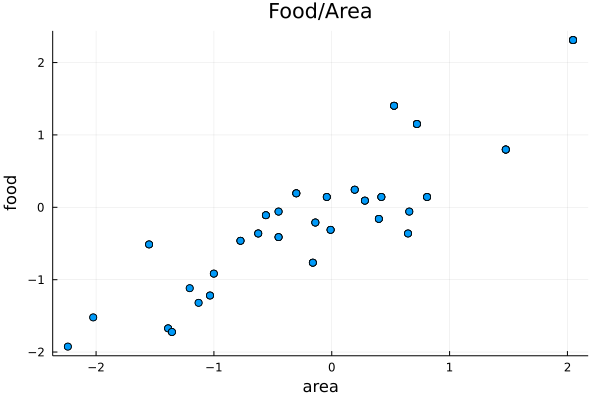

In [6]:
@df data plot(:area, :avgfood, seriestype=:scatter, title="Food/Area", xlabel="area", ylabel="food", labels=nothing, legend=false)

In [7]:
@gen function foxes_area_avgfood_model(areas)
    a ~ normal(0., 0.2)
    b ~ normal(0., 0.5)
    noise ~ gamma(1., 1.)
    
    function f(area)
        return a + b * area
    end
    
    for (i,area) in enumerate(areas)
        {(:y, i)} ~ normal(f(area), noise)
    end
    return f
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##foxes_area_avgfood_model#286", Bool[0], false)

  0.139630 seconds (517.87 k allocations: 27.819 MiB, 99.59% compilation time)


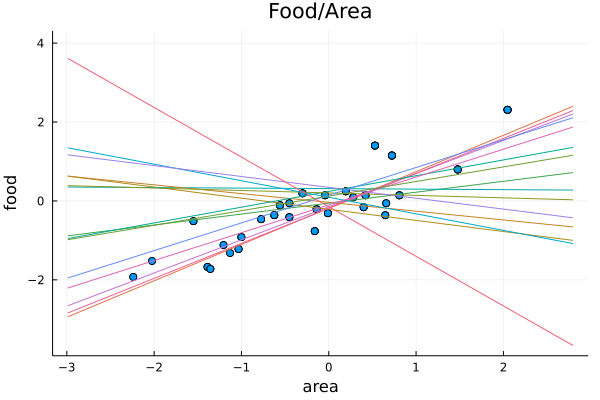

In [8]:
@df data plot(:area, :avgfood, seriestype=:scatter, title="Food/Area", xlabel="area", ylabel="food", labels=nothing, legend=false)
@time priors = [foxes_area_avgfood_model(()) for _ in 1:15]
test_xs = range(minimum(data.area)-0.75, maximum(data.area)+0.75, length=1000)
plot!(test_xs, [f.(test_xs) for f in priors], legend=false)
plot!(ylim=(minimum(data.avgfood) - 2, maximum(data.avgfood) + 2))

In [9]:
observations = Gen.choicemap()
for (i,avgfood) in enumerate(data.avgfood)
    observations[(:y, i)] = avgfood
end

warmup_traces = []
@time traces, lml_ests = sampling(foxes_area_avgfood_model, (data.area,), observations, samples=100, steps=1_000, progress=true)
#@time traces,accepted,warmup_traces,warmup_accepted = mcmc(foxes_area_avgfood_model, (data.area,), observations, kernel=Gen.hmc, warmup=500, steps=10_000, progress=true)
#accepted,warmup_accepted

Sampling: 100%|███████████████████████████| Time: 0:00:06 (60.93 μs/it)


  6.670031 seconds (141.76 M allocations: 5.435 GiB, 9.10% gc time, 24.37% compilation time)


(Any[Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##foxes_area_avgfood_model#286", Bool[0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:y, 14) => Gen.ChoiceOrCallRecord{Float64}(-0.9163369449458594, -0.08974988344823465, NaN, true), (:y, 46) => Gen.ChoiceOrCallRecord{Float64}(-0.10954312624589953, -0.5421513554705109, NaN, true), (:y, 50) => Gen.ChoiceOrCallRecord{Float64}(-0.15996773991464705, -1.0746141791685555, NaN, true), (:y, 73) => Gen.ChoiceOrCallRecord{Float64}(0.1425799420978381, -0.3703768607802418, NaN, true), (:y, 3) => Gen.ChoiceOrCallRecord{Float64}(-1.118035399620849, -0.09183799418251437, NaN, true), (:y, 29) => Gen.ChoiceOrCallRecord{Float64}(-1.218884626958344, -0.20089471293418248, NaN, true), (:y, 16) => Gen.ChoiceOrCallRecord{Float64}(-0.059118512577152005, -0.420230074150715, NaN, true), (:y, 115) => Gen.Cho

In [10]:
params = (:a, :b, :noise)

(:a, :b, :noise)

In [11]:
warmup_choicemaps = []
if !isempty(warmup_traces)
    warmup_choicemaps = Gen.get_choices.(warmup_traces)
end
choicemaps = []
if !isempty(traces)
    choicemaps = Gen.get_choices.(traces)
end

1000-element Vector{Gen.DynamicDSLChoiceMap}:
 Gen.DynamicDSLChoiceMap(Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:y, 14) => Gen.ChoiceOrCallRecord{Float64}(-0.9163369449458594, -0.08974988344823465, NaN, true), (:y, 46) => Gen.ChoiceOrCallRecord{Float64}(-0.10954312624589953, -0.5421513554705109, NaN, true), (:y, 50) => Gen.ChoiceOrCallRecord{Float64}(-0.15996773991464705, -1.0746141791685555, NaN, true), (:y, 73) => Gen.ChoiceOrCallRecord{Float64}(0.1425799420978381, -0.3703768607802418, NaN, true), (:y, 3) => Gen.ChoiceOrCallRecord{Float64}(-1.118035399620849, -0.09183799418251437, NaN, true), (:y, 29) => Gen.ChoiceOrCallRecord{Float64}(-1.218884626958344, -0.20089471293418248, NaN, true), (:y, 16) => Gen.ChoiceOrCallRecord{Float64}(-0.059118512577152005, -0.420230074150715, NaN, true), (:y, 115) => Gen.ChoiceOrCallRecord{Float64}(-1.723130763645819, -0.4823540716807926, NaN, true), (:y, 23) => Gen.ChoiceOrCallRecord{Float64}(-0.3616661945896366, -3.1030923

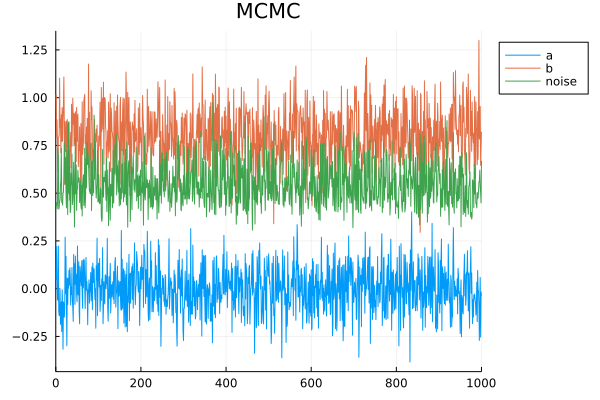

In [12]:
plt = plot(xlim=(-length(warmup_traces), length(traces)), title="MCMC", color=[:red :green :blue], legend=:outertopright)
if !isempty(warmup_traces)
    for param in params
        plot!(plt,(-length(warmup_traces)+1):0, Gen.get_value.(warmup_choicemaps, param), label="$param (warmup)")
    end
end
if !isempty(traces)
    for param in params
        plot!(plt,(1:length(traces)), Gen.get_value.(choicemaps, param), label=string(param))
    end
end

plt